In [4]:
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

# Klassennamen:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
# Trainingsdatensatz: mit Augmentation Methods wie in dem Paper
# (RandomHorizontalFlip und RandomCrop)
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
        # zufällige horizontale Spiegelung des Bildes (mit Wahrscheinlichkeit von 0,5 wird das Bild horizontal gespiegelt)
        transforms.RandomHorizontalFlip(), # Dadurch Variation der Daten, um Modell robuster gegenüber horizontalen Symmetrien zu machen
        # zufälligen Zuschnitt des Bildes auf eine Größe von 32x32 Pixeln
        transforms.RandomCrop(32) # Modellgeneralisierung verbessern (Modell muss lernen, Objekte in verschiedenen Teilen des Bildes zu erkennen)
    ]))

# Validierungsdatensatz:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
        # zufällige horizontale Spiegelung des Bildes (mit Wahrscheinlichkeit von 0,5 wird das Bild horizontal gespiegelt)
        transforms.RandomHorizontalFlip(), # Dadurch Variation der Daten, um Modell robuster gegenüber horizontalen Symmetrien zu machen
        # zufälligen Zuschnitt des Bildes auf eine Größe von 32x32 Pixeln
        transforms.RandomCrop(32) # Modellgeneralisierung verbessern (Modell muss lernen, Objekte in verschiedenen Teilen des Bildes zu erkennen)
    ]))

# Alle Flugzeug- und Vögelbilder raussuchen:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))
print(f"Training on device {device}.")


import datetime
# Trainingsloop für Validierungs- und Trainingsdaten:
def training_loop_WRN(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    trainingsloss_WRN = np.zeros(n_epochs)
    validierungsloss_WRN = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            losses_train = loss_fn(outputs, labels)
            optimizer.zero_grad()
            losses_train.backward()
            optimizer.step()
            loss_train += losses_train.item()

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            losses_val = loss_fn(outputs, labels)
            optimizer.zero_grad()
            optimizer.step()
            loss_val += losses_val.item()

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader):.4f},"
                  f" Validation loss {loss_val / len(val_loader):.4f}")

        validierungsloss_WRN[epoch-1] = loss_val / len(val_loader) # Valideriungsverlust
        trainingsloss_WRN[epoch-1] = loss_train / len(train_loader) # Trainingsverlust

    return trainingsloss_WRN, validierungsloss_WRN

# resnet aus dem Paper:
# 28 B(3,3) Blöcke mit k=2, [WRN 28 2 B(3,3)]
# # batch --> relu --> convolution

# Definition des Wide Residual Networks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential() # Dimensionen anpassen, falls sie nicht übereinstimmen
        # Falls eine Anpassung erforderlich ist, wird die Shortcut-Verbindung definiert
        # besteht aus einer 1x1 Convolutional Layer und einer Batch-Normalisierungsschicht und ReLu
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        residual = x # Eingabetensor

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        out += self.shortcut(residual)

        return out


class WideResNet(nn.Module):
    def __init__(self, num_blocks, widening_factor, num_classes=10):
        super(WideResNet, self).__init__()
        self.in_channels = 16 # Anzahl der Eingangskanäle

        self.bn1 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # Erstellung der Schichten
        self.layer1 = self._make_layer(16 * widening_factor, num_blocks, stride=1)
        self.layer2 = self._make_layer(32 * widening_factor, num_blocks, stride=2)
        self.layer3 = self._make_layer(64 * widening_factor, num_blocks, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) #  Definition einer adaptiven Average Pooling-Schicht
        self.fc = nn.Linear(64 * widening_factor, num_classes) # lineare Schicht

    # interne Hilfsmethode, die eine Schicht aus Residualblöcken erstellt
    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride)) # Hinzufügen eines Residualblocks zur Liste
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels)) #  Hinzufügen weiterer Residualblöcke zur Liste
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.layer1(out) # Durchlaufen der ersten Schicht von Residualblöcken
        out = self.layer2(out) # Durchlaufen der zweiten Schicht von Residualblöcken
        out = self.layer3(out) # Durchlaufen der dritten Schicht von Residualblöcken

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# Training WideResNet:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                           shuffle=True)


depth = 28  # Anpassung des Werts für depth
widening_factor = 2  # Anpassung des Werts für den Widening-Faktor
model = WideResNet(num_blocks=(depth-4)//6, widening_factor=widening_factor, num_classes=2).to(device=device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

trainingsloss_WRN, validierungsloss_WRN = training_loop_WRN(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

Files already downloaded and verified
Files already downloaded and verified
Training on device cuda.
Epoch 1, Training loss 0.4705, Validation loss 0.5040
Epoch 10, Training loss 0.1892, Validation loss 0.3553
Epoch 20, Training loss 0.0455, Validation loss 1.0297
Epoch 30, Training loss 0.0287, Validation loss 0.7145
Epoch 40, Training loss 0.0095, Validation loss 0.8717
Epoch 50, Training loss 0.0117, Validation loss 0.7104
Epoch 60, Training loss 0.0047, Validation loss 0.8296
Epoch 70, Training loss 0.0033, Validation loss 0.7469
Epoch 80, Training loss 0.0368, Validation loss 0.8331
Epoch 90, Training loss 0.0037, Validation loss 0.8077
Epoch 100, Training loss 0.0013, Validation loss 0.8667


Accuracy train: 1.00
Accuracy val: 0.87


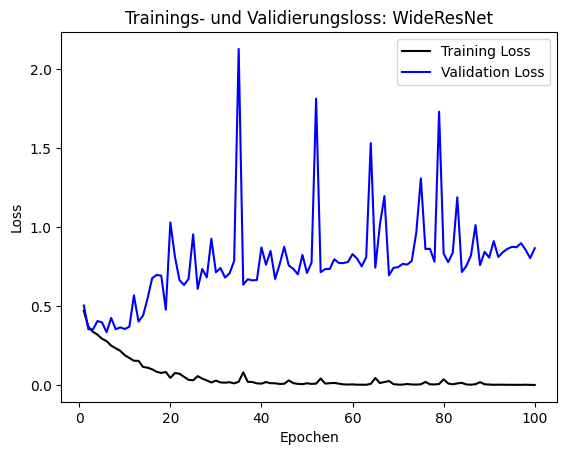

In [5]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                        shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                       shuffle=False)

train_loader = [(img.to(device=device), label.to(device=device)) for img, label in train_loader]
val_loader = [(img.to(device=device), label.to(device=device)) for img, label in val_loader]


def validate_WRN(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate_WRN(model, train_loader, val_loader)

# Trainings- und Validierungsloss WideResNet

epochs_train = range(1, len(trainingsloss_WRN) + 1)
epochs_val = range(1, len(validierungsloss_WRN) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss_WRN, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss_WRN, 'b', label='Validation Loss')
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.title('Trainings- und Validierungsloss: WideResNet')
plt.legend(loc="best")
plt.show()


In [6]:
# Trainingsdatensatz: ohne Augmentation Methods wie in dem Paper

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),

    ]))

# Validierungsdatensatz:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ]))

# Alle Flugzeug- und Vögelbilder raussuchen:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# ResNet architecture:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out  # teil überspringen
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Trainingsloop für Validierungs- und Trainingsdaten:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    trainingsloss = np.zeros(n_epochs)
    validierungsloss = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            losses_train = loss_fn(outputs, labels)
            optimizer.zero_grad()
            losses_train.backward()
            optimizer.step()
            loss_train += losses_train.item()

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            losses_val = loss_fn(outputs, labels)
            optimizer.zero_grad()
            optimizer.step()
            loss_val += losses_val.item()

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader):.4f},"
                  f" Validation loss {loss_val / len(val_loader):.4f}")

        validierungsloss[epoch-1] = loss_val / len(val_loader) # Valideriungsverlust
        trainingsloss[epoch-1] = loss_train / len(train_loader) # Trainingsverlust

    return trainingsloss, validierungsloss

# Training ResNet aus dem Buch:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                           shuffle=True)

model = NetRes(n_chans1=32).to(device=device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

trainingsloss, validierungsloss = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)


Epoch 1, Training loss 0.6390, Validation loss 0.5555
Epoch 10, Training loss 0.3360, Validation loss 0.3317
Epoch 20, Training loss 0.2863, Validation loss 0.3133
Epoch 30, Training loss 0.2538, Validation loss 0.2691
Epoch 40, Training loss 0.2181, Validation loss 0.3061
Epoch 50, Training loss 0.1896, Validation loss 0.2556
Epoch 60, Training loss 0.1631, Validation loss 0.3513
Epoch 70, Training loss 0.1371, Validation loss 0.3953
Epoch 80, Training loss 0.1119, Validation loss 0.2921
Epoch 90, Training loss 0.0901, Validation loss 1.0077
Epoch 100, Training loss 0.0722, Validation loss 0.3370


Accuracy train: 0.98
Accuracy val: 0.90


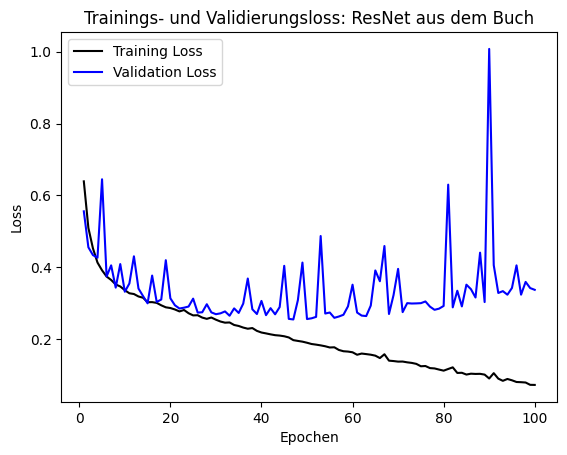

In [10]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                        shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                       shuffle=False)

train_loader = [(img.to(device=device), label.to(device=device)) for img, label in train_loader]
val_loader = [(img.to(device=device), label.to(device=device)) for img, label in val_loader]

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

# Trainings- und Validierungsloss WideResNet

epochs_train = range(1, len(trainingsloss) + 1)
epochs_val = range(1, len(validierungsloss) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss, 'b', label='Validation Loss')
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.title('Trainings- und Validierungsloss: ResNet aus dem Buch')
plt.legend(loc="best")
plt.show()

Vergleich der beiden Netzwerke:

Die "Accuracy" bei Verwendung des Netzwerkes aus dem Paper "Wide Residual Networks" fällt im Vergleich zur Verwendung des Netzwerkes aus dem Buch. Das Overfitting wird stärker. Das heißt, dass der Validierungs- und Trainingsloss über der Anzahl an Epochen weiter auseinander geht.